In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams as rc
rc['figure.figsize'] = 10, 8
rc['axes.labelsize'] = 16
rc['axes.titlesize'] = 20
rc['legend.fontsize'] = 16

from astropy import constants as c
import math as mt
from scipy.special import gamma
from matplotlib import cm as cmap
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
from astropy import constants as cst

In [ ]:
#define some constants
# Constants in cgs units
c = 3e10  # Speed of light (cm/s)
m_e = 1e-27  # Electron mass (g)
e = 4.803e-10  # Elementary charge (esu)
M_sun = 2e33  # Sun's mass (g)
G = 7e-8  #Gravitational constant (erg cm / g^2)
h = 6.626176e-27   # Planck's constant in Erg Second

M = 4e6 * M_sun  # Sgr A*'s mass
Lj = 9e37  # Accretion power (erg/s) (derived in the notes)
r_g = G * M / c**2  #Gravitational radius
r_i = 10 * r_g  # Initial radius (cm)
r_f = 1000 * r_g  # Final radius (cm)
theta = mt.radians(10)  #opening angle of 10 degrees converted to radiants
v = 0.3 * c  # Bulk velocity (cm/s)
d = 2.5e22 # Distance from Sgr A* (cm)
p = 2
V = (4/3)*np.pi*r_i**3 #volume of lobe
pitch = np.pi/2 # pitch angle in radians
Ledd = 1.26e38 * M   # Eddington luminosity in erg/s
eta = 1e-7           # radiative efficiency

#ranges:
eta_values = np.linspace(0.1, 1.5, 5)
r_values = np.logspace(np.log10(r_i), np.log10(r_f), 501)
nu_values = np.logspace(7, 14, 500)
dr_values = np.ediff1d(r_values)
r_values=r_values[:-1]
E = np.logspace(0, 3) * m_e * c**2

omega = 2*np.pi*nu_values   # angular frequency

In [73]:
dr_values[0] / dr_values

array([1.        , 0.99083194, 0.98174794, 0.97274722, 0.96382902,
       0.95499259, 0.94623716, 0.93756201, 0.92896639, 0.92044957,
       0.91201084, 0.90364947, 0.89536477, 0.88715601, 0.87902252,
       0.87096359, 0.86297855, 0.85506671, 0.84722741, 0.83945999,
       0.83176377, 0.82413812, 0.81658237, 0.8090959 , 0.80167806,
       0.79432823, 0.78704579, 0.77983011, 0.77268059, 0.76559661,
       0.75857758, 0.75162289, 0.74473197, 0.73790423, 0.73113908,
       0.72443596, 0.71779429, 0.71121351, 0.70469307, 0.6982324 ,
       0.69183097, 0.68548823, 0.67920363, 0.67297666, 0.66680677,
       0.66069345, 0.65463617, 0.64863443, 0.64268772, 0.63679552,
       0.63095734, 0.62517269, 0.61944108, 0.61376201, 0.608135  ,
       0.60255959, 0.59703529, 0.59156163, 0.58613816, 0.58076442,
       0.57543994, 0.57016427, 0.56493697, 0.5597576 , 0.55462571,
       0.54954087, 0.54450265, 0.53951062, 0.53456436, 0.52966344,
       0.52480746, 0.519996  , 0.51522864, 0.510505  , 0.50582

In [74]:
#plot each equaetion from hw
#part a)

def B(r, dr):
    """
    this function calculates the magnetic field for a given bulk velocity and accretion power over a range of radius

    parameters
    ---------
    r: np.ndarray
        array of radii of the expanding jet
    Lj: float
        accretion power [erg/s] (derived in the notes)

    returns
    ----------
    B: np.ndarray
        array of magnetic field values around the jet over a range of radii
    """
    return (1/r) * np.sqrt((4*Lj)/v) #* (dr[0] / dr) #i had a 2 idk why its 4 but it gets me closer to correct spectrum

def C(r, dr):
    """
    this function calculates the constant C in the definition of the absorption coefficient

    parameters
    -----------
    B: np.ndarray
        array of magnetic field values around the jet over a range of radii

    returns
    ---------
    C: np.ndarray
        array of the lorentz boosted electromagnetic energy
    """
    return (B(r, dr))**2 / (24 * np.pi * np.log(10))

#part b)
#absorption coefficient from R&L 6.53
def absorption(nu, dr):
    """
    This function calculates the absorption co-efficient at the given frequency.
    The equation used can be found in 6.53 R&L.

    Parameters
    ----------
    B: np.ndarray
        array of magnetic field values around the jet over a range of radii
    C: np.ndarray
        array of the lorentz boosted electromagnetic energy
    nu: np.ndarray
        the frequency of light to evaluate at

    Returns
    -------
    alpha_nu: np.ndarray
        array of absorption co-efficients at time t for the given range of frequencies
    """
    comp_1 = (np.sqrt(3) * e**3) / (8 * np.pi * m_e)
    comp_2 = np.power((3 * e)/(2 * np.pi * m_e**3 * c**5), p / 2)
    comp_3 = C(r, dr) * np.power(B(r, dr) * np.sin(pitch), (p + 2) / 2)
    comp_4 = mt.gamma((3 * p + 2) / 12) * mt.gamma((3 * p + 22) / 12)
    comp_5 = np.power(nu, -(p + 4) / 2)
    alpha_nu = comp_1 * comp_2 * comp_3 * comp_4 * comp_5
    return alpha_nu

def optical_depth(r, dr, nu):
    return absorption(nu, dr) * r

#synchrotron power
def p_tot_nu(r, dr, p):
    """
    This function calculates the total power per unit volume per unit frequency.
    The equation can be found in 6.36 R&L.

    Parameters
    ----------
    B: np.ndarray
        array of magnetic field values around the jet over a range of radii
    C: np.ndarray
        array of the lorentz boosted electromagnetic energy

    Returns
    -------
    p_tot_nu: np.ndarray
        total power per unit volume per unit frequency evaluated at each time step t.
    """
    comp_1 = (np.sqrt(3) * e**3 * C(r, dr) * B(r, dr) * np.sin(pitch)) / (2 * np.pi * m_e * c**2 * (p + 1))
    comp_2 = mt.gamma(p / 4 + 19 / 12) * mt.gamma(p / 4 - 1 / 12)
    comp_3 = np.power((m_e * c * omega) / (3 * e * B(r, dr) * np.sin(pitch)), -(p - 1) / 2)
    p_tot_omega = comp_1 * comp_2 * comp_3 #total power per unit volume per angular frequency
    return 2 * np.pi * p_tot_omega #total power per unit volume per unit frequency



#synchrotron source
def S_nu(r, dr, nu, p):
    """
    This function calculates the source function of the blob at each time step

    Parameters
    ----------
    p_tot_nu: np.ndarray
        total power per unit volume per unit frequency evaluated at each time step t.
    alpha_nu: np.ndarray
        array of absorption co-efficients at time t for the given frequency

    Returns
    -------
    S_nu: np.ndarray
        source function at each time step t.
    """
    return p_tot_nu(r, dr, p)/(4 * np.pi * absorption(nu, dr))

#synchrotron intensity
def I_nu(r, dr, nu, p):
    """
    This function calculates the intensity of the source at time t.

    Parameters
    ----------
    S: np.ndarray
        source function at each time step t.
    tau: np.ndarray
        optical depth at each time step t.

    Returns
    -------
    I: np.ndarray
        intensity at each time step t.
    """
    return S_nu(r, dr, nu, p) * (1 - np.exp(-optical_depth(r, dr, nu)))


#synchrotron flux
def flux(r, dr, nu, p, d):
    """
    This function calculates the flux of lobes at earth in mJy.

    Parameters:
    -----------
    P: np.ndarray
        Array of powers at given frequencies
    V: float
        volume of the lobes
    D: float
        Distance to the lobes from earth
    """
    return  I_nu(r, dr, nu, p) * r * dr / (np.tan(theta/2) * 4 * np.pi * d**2)
    #return I_nu * r * dr * np.tan(theta/2) / (4 * np.pi * d**2)

# Obtaining a photon distribution
The first step to be able to use the Monte Carlo tutorial is to obtain a probability distribution function (PDF) for the photons in the jet. Using the code that calculated the flux, we will do so in the following steps:

1. Plot the intensity of the first slice
    * The intensity of each slice is already calculated in the code we wrote for the flat jet spectrum. We use that value, making sure we only plot the intensity of the first slice.
2. Move from the intensity to a unit with number of photons
3. Normalise
    * Now we need to normalise the area under the curve, this is done by dividing the number of photons array, by the area under the graph.
4. Sample the distribution

[1.00000000e+07 1.03282813e+07 1.06673394e+07 1.10175281e+07
 1.13792129e+07 1.17527712e+07 1.21385926e+07 1.25370799e+07
 1.29486487e+07 1.33737286e+07 1.38127630e+07 1.42662102e+07
 1.47345431e+07 1.52182505e+07 1.57178372e+07 1.62338243e+07
 1.67667503e+07 1.73171713e+07 1.78856616e+07 1.84728144e+07
 1.90792422e+07 1.97055780e+07 2.03524752e+07 2.10206088e+07
 2.17106760e+07 2.24233968e+07 2.31595149e+07 2.39197984e+07
 2.47050406e+07 2.55160607e+07 2.63537052e+07 2.72188479e+07
 2.81123917e+07 2.90352688e+07 2.99884423e+07 3.09729067e+07
 3.19896892e+07 3.30398507e+07 3.41244871e+07 3.52447300e+07
 3.64017485e+07 3.75967497e+07 3.88309805e+07 4.01057288e+07
 4.14223247e+07 4.27821420e+07 4.41865996e+07 4.56371628e+07
 4.71353453e+07 4.86827104e+07 5.02808725e+07 5.19314994e+07
 5.36363132e+07 5.53970928e+07 5.72156756e+07 5.90939590e+07
 6.10339029e+07 6.30375315e+07 6.51069356e+07 6.72442742e+07
 6.94517777e+07 7.17317494e+07 7.40865683e+07 7.65186915e+07
 7.90306568e+07 8.162508

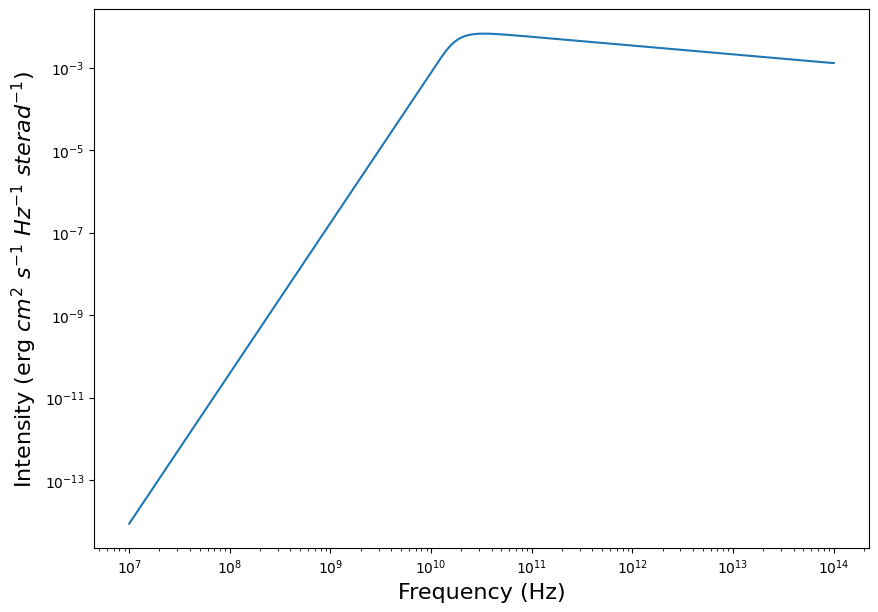

In [75]:
def jet_spectrum(r, dr, nu, p=2):
    """
    This function takes the intensity of a jet slice and
    returns a normalised photon distribution.

    Parameters
    ----------
    r: float
        Value of distance r

    Returns
    -------
    norm_photon: np.ndarray
        Normalised photon distribution.
    """

    # 1. Plot the intensity of the first slice
    I_v = I_nu(r, dr, nu, p)

    # 2. Obtain the number density
    no_photons = I_v / h * nu

    # 3. Normalise
    area = np.sum(no_photons)
    norm_photon = no_photons / area
    return norm_photon

fig1 = plt.figure(figsize=(10, 7))
jet_spectrum_pdf = jet_spectrum(r_values, dr_values, nu_values, p)

print(nu_values)

plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Intensity (erg $cm^2$ $s^{-1}$ $Hz^{-1}$ $sterad^{-1}$)', fontsize=16)
plt.plot(nu_values, jet_spectrum_pdf)
plt.xscale('log')
plt.yscale('log')
plt.show()

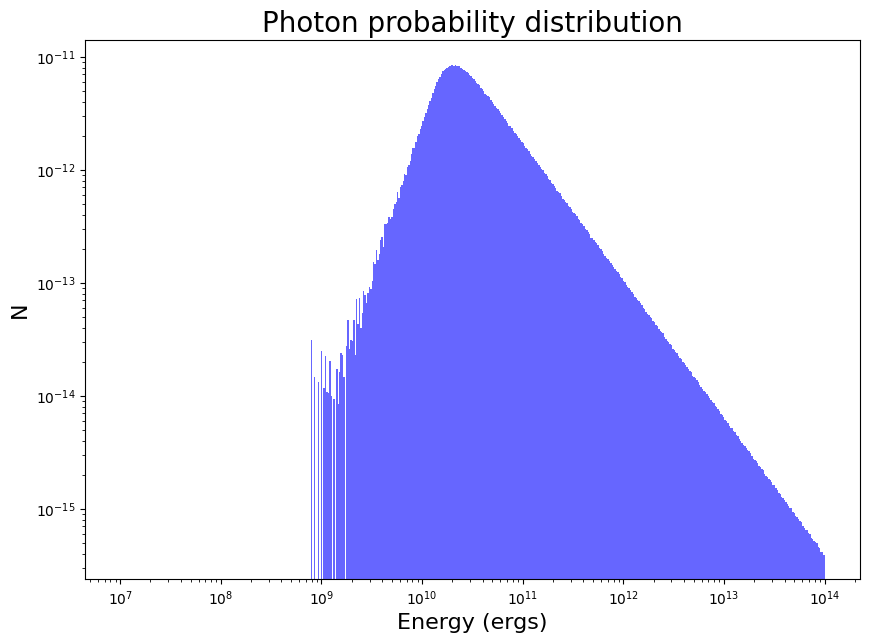

In [ ]:
# 4. Sample the distribution

def photon_distr(n, jet_spectrum, nu_values):
    """
    This function samples a previously obtained, normalised photon distribution.

    Parameters
    ----------
    n: int
        Number of photons

    jet_spectrum: ndarray
        Jet spectrum

    nu_values: ndarray
        Range of frequencies

    Returns
    -------
    v_inv: ndarray
        Sampled photon distribution.
    """
    cdf = np.cumsum(jet_spectrum_pdf)
    u = np.random.uniform(0, 1, size = n)
    v_inv = np.interp(u, cdf, nu_values)

    return v_inv


photon_pdf_samples = photon_distr(5000*500, jet_spectrum_pdf, nu_values)
fig2 = plt.figure(figsize=(10, 7))
plt.hist(photon_pdf_samples, bins= nu_values, density=True, alpha=0.6, color='b', log=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (ergs)')
plt.ylabel('N')
plt.title('Photon probability distribution', fontsize=20)
plt.show()

# Obtaining an electron ditribution

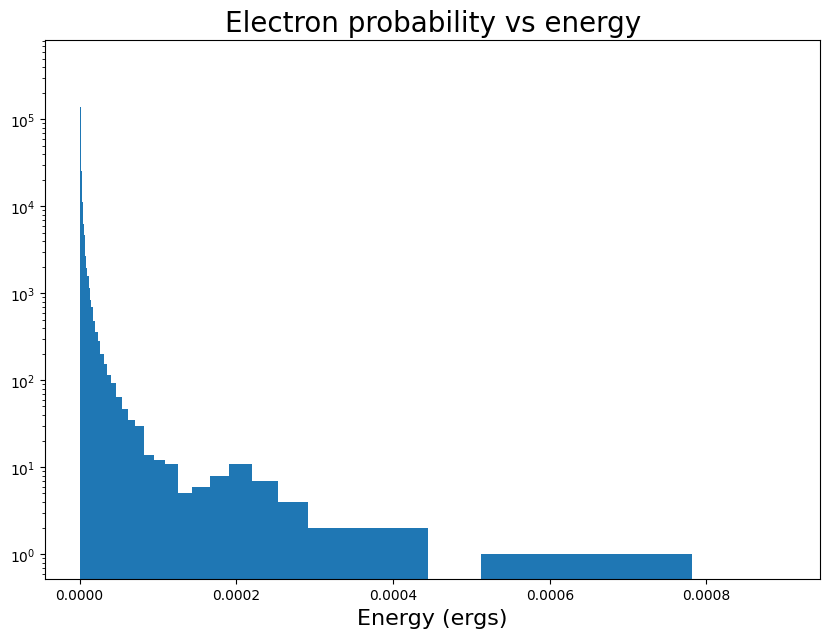

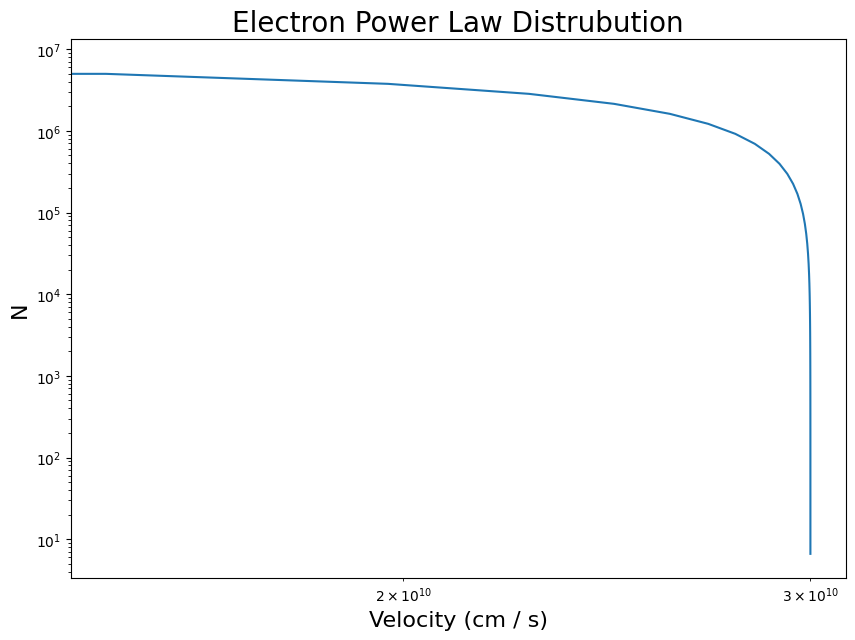

In [ ]:
def electron_power_law(E, r, p = 2):
    """
    Calculates a power law distribution for the electrons inside of the jet.

    Parameters
    ----------
    E: ndarray
        Range of energies

    r: int
        Distance from the origin (number of the slice)

    p: float
        Range of frequencies

    Returns
    -------
    no_e: ndarray
        Electron distribution.
    """
    # 1. Obtain the number density of electrons from the power law
    constant = C(r)
    C_hat = m_e * c**2 * constant
    no_e = C_hat * E**(-p)
    return no_e

no_e = electron_power_law(E, r[0], p = 2)

def sample_electrons(n, no_e, energy):

    """
    Adapted from demo.ipynb. Samples the electron distribution.

    Parameters
    ----------
    n: int
        Number of electrons

    no_e: ndarray
        Electron distribution

    energy: ndarray
        Energy range

    Returns
    -------
    v_inv: ndarray
        Sampled electron distribution.
    """


    # 2. Normalize (obtaining the probability density function)
    electron_pdf = no_e / (np.sum(no_e))

    # 3. Sample
    cdf = np.cumsum(electron_pdf)
    u = np.random.uniform(0, 1, size = n)
    v_inv = np.interp(u, cdf, energy)
    return v_inv


electron_pdf_sample = sample_electrons(int(1e6), no_e, E)
no_e = electron_power_law(E, r[0], p = 2)

fig3 = plt.figure(figsize=(10, 7))
plt.hist(electron_pdf_sample, bins = E)
#plt.plot(E, no_e)
plt.title('Electron probability vs energy')
plt.xlabel('Electron probability')
plt.xlabel('Energy (ergs)')
plt.yscale('log')
plt.yscale('log')
plt.show()


def velocities(energy, rest_mass):
    """
    Calculates the velocities of the sampled electrons.

    Parameters
    ----------
    energy: ndarray
        Energy range

    rest_mass: ndarray

    Returns
    -------
    v: ndarray
        Velocity array.
    """
    gamma = energy / (rest_mass * c**2)
    v = c * np.sqrt( 1 - gamma**(-2))
    return v

fig4 = plt.figure(figsize=(10, 7))
plt.plot(velocities(E, m_e), no_e)
plt.xscale('log')
plt.yscale('log')
plt.title('Electron Power Law Distrubution')
plt.xlabel('Velocity (cm / s)')
plt.ylabel('N')
plt.show()

# Monte Carlo simulation
Now, having written the electron and photon sampling functions we are able to feed it back to our MC simulation.

In [ ]:
c_light=3.e10
m_electron=9.10938356e-28
sigma_t=6.65e-25
figure_counter=0

def compton_y(pre,post):
    y = np.mean((post-pre)/pre)
    return(y)

def random_direction(number=None):
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())

def f_of_hnu_mono(mc_parms,number=None):
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

def photon_origin(number=None):
    if number is None:
        number=1
    return(np.zeros([number,3]))

def draw_seed_photons(mc_parms,number=None):
    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

def tau_of_scatter():
    return(-np.log(np.random.rand()))

def distance_of_scatter(mc_parms):
    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density
    return(distance)

def scatter_location(x_old,p_photon,mc_parms):
    distance = distance_of_scatter(mc_parms)
    photon_direction=p_photon[1:]/p_photon[0]
    x_new = x_old + distance*photon_direction
    return(x_new)

def f_of_v_mono(mc_parms):
    return(mc_parms['velocity'])

def draw_electron_velocity(mc_parms,p_photon):
    v=mc_parms['v_dist'](mc_parms)
    n=draw_electron_direction(v,p_photon)
    return(v*n)

def draw_electron_direction(v,p_photon):
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p_electron(v/c_light,np.random.rand())
    sint=np.sqrt(1 - cost**2)

    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))

def mu_of_p_electron(b,p):
    mu=(4*p-2-b)/(1+np.sqrt(1+b*(2-4*p)+b**2))
    return(mu)

def lorentz_transform(p,v):
    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

def cos_theta_thomson(p):
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

def thomson_scatter(p_photon):
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

def inverse_compton_scatter(p_photon,mc_parms):
    velocity=draw_electron_velocity(mc_parms,p_photon)
    p_photon_prime=lorentz_transform(p_photon,velocity)
    p_out_prime=thomson_scatter(p_photon_prime)
    return(lorentz_transform(p_out_prime,-velocity))

def monte_carlo(mc_parms):
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        hnu_seed[i]=p_photon[0]*c_light
        scattered=True
        while (scattered):
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0
        hnu_scattered[i]=p_photon[0]*c_light
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    global figure_counter
    if (xlims is None):
        xlims=[0.1,100]
    if (bins is None):
        bins=np.logspace(np.log10(hnu_scattered.min()),np.log10(hnu_scattered.max()),num=100)
    if (filename is None):
        filename='inverse_compton_MC_{0:d}.pdf'.format(figure_counter)
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds']
    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins, log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    # plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$')
    plt.ylabel(r'$N(h\nu)$')
    plt.legend()
    fig.savefig(filename)
    figure_counter+=1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

In [ ]:
# Some extra functions that will let us feed it the output of the sampling into the MC.
def v_power(mc_parms, no_e = no_e, E = E):
    """
    Applies the MC parameters to the electron distribution.

    Parameters
    ----------
    mc_parms: dict
        MC parameters

    no_e: ndarray
        Array of electron

    E: ndarray
        Energy array

    Returns
    -------
    samples: ndarray
        Sample array.
    """
    r = np.random.rand()
    g = (1-r)**(1/(1-2))
    b = 1 - 1/g**2
    return b*c
    n = 1
    samples = sample_electrons(n, no_e, E)
    samples = velocities(E, m_e)

    return samples


def f_of_jet_slice(mc_parms, r=r, nu_values = nu_values, number=None,pdf=None,energies=None):
    if number == None:
        number = 1
    n = number
    jet_pdf = jet_spectrum(r)
    samples = photon_distr(n, jet_spectrum, nu_values)

    return samples

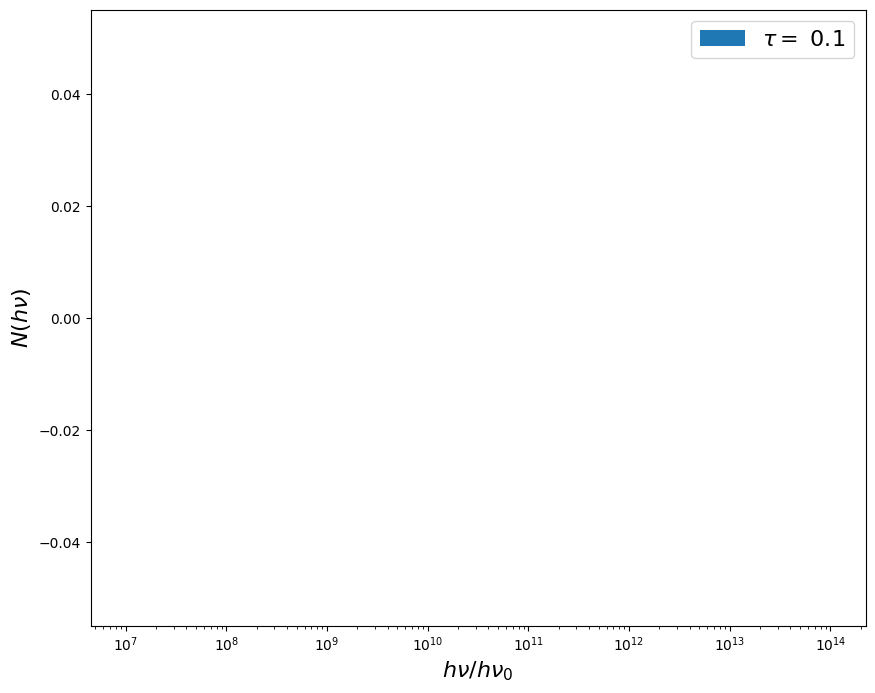

Fraction of escaping photons: 8.501e-01

Compton y parameter: 1.035e+03



In [ ]:
# now we just put everything together
# Run an example of a Monte Carlo simulation for optical depth 0.1

mc_parms={'n_photons':int(1e4),         # start somewhat small and go up
            'kt_seeds':1.6e-9,         # 1 keV input photons
            'H':r[0],                   # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
            'velocity':3e10 * 0.3,            # 10% speed of light--pretty hot
            'tau':0.1,                 # tau ~ 0.1: Small-ish optical depth # t=1 for photosphere
            'v_dist':v_power,      # name of velocity distribution function
            'gamma_min': 0,
            'gamma_max': 3, # range for electron gamma 1e0 to 1e3
            'hnu_dist':f_of_jet_slice,  # name of photon distribution function
            }

hnu_scattered, hnu_seeds=plot_mc(mc_parms, bins=nu_values, xlims=[1, 1e10])


This is how far I managed to get, figuring out how to use the MC properly and how to sample the  distributions took way longer than I wanted it to.